In [3]:
pip install -r install.txt

     |████████████████████████████████| 23.6MB 19.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Vegetation Index
### *Using NDVI (Normalized Difference Vegetation Index)

To calculate the NDVI, we need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for these bands. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:

$$NDVI = \frac{nir - red}{nir + red} $$




In [144]:
import rasterio as rio
import numpy as np
from PIL import Image, ImageDraw
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors



# The initial release contains only one tile, so lets hardcode its location
# here.  When you have more tiles, you can update this
TILE_X = 7680
TILE_Y = 10240

# The expected value of a Pixel in a mask file indicating that the pixel is
# within that region.  Tuple value, (Red, Green, Blue, Alpha)
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)

# Tile width / height in pixels

TILE_WIDTH_PX = 512
TILE_HEIGHT_PX = 512

def get_cropped_image_paths(tile_x, tile_y, band, date):
    path = f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/cropped/cropped-{tile_x}-{tile_y}-{band}-{date}.png"
    #path = glob.glob(path)
    #path = path[0] # get the first date 
    return path 

def get_red(tile_x, tile_y, date):
    band = 'B04'
    path = get_cropped_image_paths(tile_x, tile_y, band , date)
    b4 = rio.open(path)
    red = b4.read()
    return red.astype(float)
    
def get_nir(tile_x, tile_y, date):
    band = 'B08'
    path = get_cropped_image_paths(tile_x, tile_y, band, date)
    b8 = rio.open(path)
    nir = b8.read()
    return nir.astype(float)

def NDVI(tile_x, tile_y, date):
    red = get_red(tile_x, tile_y, date)
    nir = get_nir(tile_x, tile_y, date)
    return (nir-red)/(nir+red)

In [141]:
ndvi = NDVI(TILE_X, TILE_Y,'2016-12-22')

min=np.min(ndvi)
max=np.max(ndvi)
print(min);print(max)

ndvi_scale = ndvi - min
max = np.max(ndvi_scale)
ndvi_scale = ndvi_scale/max # scale to 0~100%
print(np.min(ndvi_scale));print(np.max(ndvi_scale))


-0.04728132387706856
0.7744360902255639
0.0
1.0


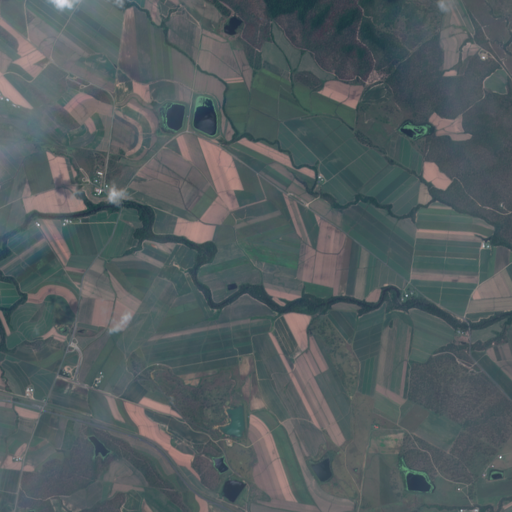

In [142]:
img = Image.open(get_timeseries_image_paths(TILE_X, TILE_Y,date = '2016-12-22', band = 'TCI'))
img

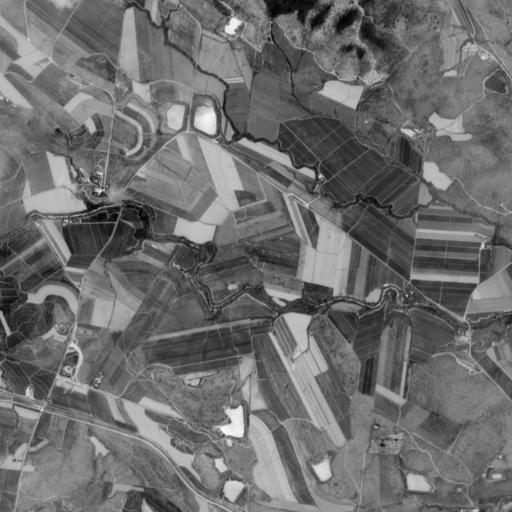

In [143]:
ndvi_seq = []
for i in range(512):
    for j in range(512):
        ndvi_seq.append(255-255*ndvi_scale[0,i,j])
        
grey_ndvi = Image.new("L", (512,512))
grey_ndvi.putdata(ndvi_seq)
grey_ndvi

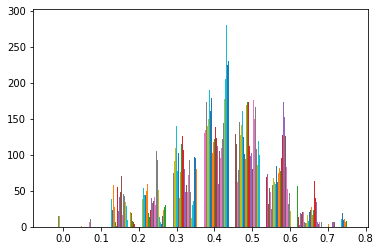

In [50]:
plt.hist(ndvi[0])
plt.show()

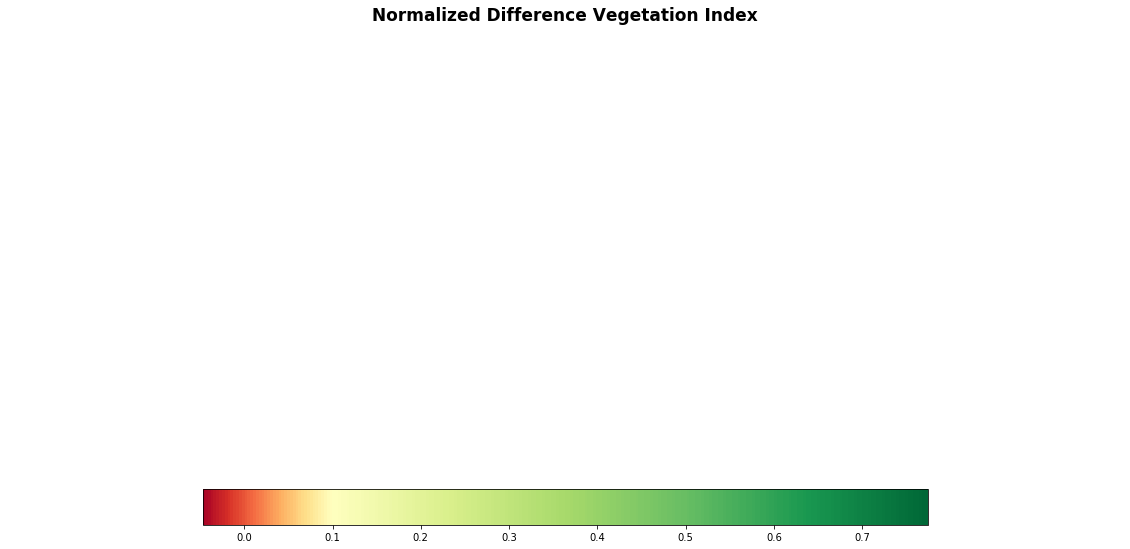

In [75]:
class MidpointNormalize(colors.Normalize):
   
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
       
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

# Set min/max values from NDVI range for image

min=np.min(ndvi)
max=np.max(ndvi)

# Set our custom midpoint for most effective NDVI analysis
mid=0.1

# Setting color scheme ref:https://matplotlib.org/users/colormaps.html as a reference
colormap = plt.cm.RdYlGn 
norm = MidpointNormalize(vmin=min, vmax=max, midpoint=mid)
fig = plt.figure(figsize=(20,10))


ax = fig.add_subplot(111)

# Use 'imshow' to specify the input data, colormap, min, max, and norm for the colorbar
#cbar_plot = ax.imshow(img, cmap=colormap, vmin=min, vmax=max, norm=norm)


# Turn off the display of axis labels 
ax.axis('off')

# Set a title 
ax.set_title('Normalized Difference Vegetation Index', fontsize=17, fontweight='bold')

# Configure the colorbar
cbar = fig.colorbar(cbar_plot, orientation='horizontal', shrink=0.65)

# Call 'savefig' to save this plot to an image file
#fig.savefig("ndvi-image.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

# let's visualize
plt.show()